# DAgger (Dataset Aggregation)

In Behavioral Cloning (BC), we have seen the method to learn expert's behavior with a manner of solving regression/classification problems.

However, it sometimes happens that the learner encounters unknown states that the expert never encounters in her/his successful demonstrations. A small error at early time-step may then lead to further mistakes, leading to poor performance.<br>
DAgger addresses this problem by collecting the additional dataset of trajectories under the state distribution induced by the learned policy.

Unlike previous behavior cloning (BC) example, DAgger queries an expert **online** for demonstrations.<br>
This eventually reduces the size of training demonstrations to obtain satisfactory performance (compared to vanilla behavior cloning), but it's limited to the case in which the trainer can query an expert online (interactively) for demonstrations.

I note that DAgger essentially differs from the incremental learning, in which RL method follows to refine the trained policy. Unlike reinforcement learning (RL), DAgger doesn't also use the rewards to refine the policy.

> Note : However, you can progressively combine behavior cloning (BC), data aggregation (DAgger), and reinforcement learning (RL) for refinement to improve performance.<br>
> See [here](https://developer.nvidia.com/blog/training-sim-to-real-transferable-robotic-assembly-skills-over-diverse-geometries/) for real Robotics example in NVIDIA.

Now let's start.

*(back to [index](https://github.com/tsmatz/imitation-learning-tutorials/))*

Before we start, we need to install the required packages.

In [ ]:
!pip install torch numpy matplotlib

## Restore environment

Firstly, I restore GridWorld environment from JSON file.

For details about this environment, see [Readme.md](https://github.com/tsmatz/imitation-learning-tutorials/blob/master/Readme.md).

> Note : See [this script](./00_generate_expert_trajectories.ipynb) for generating the same environment.

In [1]:
import numpy as np
import random

GRID_SIZE = 50
MAX_TIMESTEP = 200

class GridWorld:
    """
    This environment is motivated by the following paper.
    https://proceedings.mlr.press/v15/boularias11a/boularias11a.pdf

    - It has 50 x 50 grids (cells).
    - The agent has four actions for moving in one of the directions of the compass.
    - If ```transition_prob``` = True, the actions succeed with probability 0.7,
      a failure results in a uniform random transition to one of the adjacent states.
    - A reward of 10 is given for reaching the goal state, located on the bottom-right corner.
    - For the remaining states,
      the reward function was randomly set to 0 with probability 2/3
      and to −1 with probability 1/3.
    - If the agent moves across the border, it's given the fail reward (i.e, reward=`-1`).
    - The initial state is sampled from a uniform distribution.
    """

    def __init__(self, reward_map, valid_states, transition_prob=True):
        """
        Initialize class.

        Parameters
        ----------
        reward_map : float[GRID_SIZE * GRID_SIZE]
            Reward for each state.
        valid_states : list(int[2])
            List of states, in which the agent can reach to goal state without losing any rewards.
            Each state is a 2d vector, [row, column].
            When you call reset(), the initial state is picked up from these states.
        transition_prob : bool
            True if transition probability (above) is enabled.
            False when we generate an expert agent without noise.
        """
        self.reward_map = np.array(reward_map)
        self.valid_states = np.array(valid_states)
        self.transition_prob = transition_prob

    def reset(self):
        """
        Randomly, get initial state (single state) from valid states.

        Returns
        ----------
        state : int
            Return the picked-up state id.
        """
        # initialize step count
        self.step_count = 0
        # pick up sample of valid states
        state_2d = random.choice(self.valid_states)
        # convert 2d index to 1d index
        state_1d = state_2d[0] * GRID_SIZE + state_2d[1]
        # return result
        return state_1d

    def step(self, action, state):
        """
        Take action, proceed step, and return the result.

        Parameters
        ----------
        action : int
            Actions to take
            (0=UP 1=DOWN 2=LEFT 3=RIGHT)
        state : int
            Current state id.

        Returns
        ----------
        new-state : int
            New state id.
        reward : int
            The obtained reward.
        done : bool
            Flag to check whether it terminates.
        """
        # if transition prob is enabled, apply transition
        if self.transition_prob:
            # the action succeeds with probability 0.7
            prob = [.1]*4
            prob[action] *= 7.0
            action_onehot = np.random.multinomial(1, prob)
        else:
            action_onehot = np.zeros(4, dtype=int)
            action_onehot[action] += 1
        # get 2d state
        mod, reminder = divmod(state, GRID_SIZE)
        state_2d = np.array([mod, reminder])
        # move state
        # (0=UP 1=DOWN 2=LEFT 3=RIGHT)
        up_and_down = action_onehot[1] - action_onehot[0]
        left_and_right = action_onehot[3] - action_onehot[2]
        new_state = state_2d + np.array([up_and_down, left_and_right])
        # set reward
        reward = 0.0
        if (new_state[0] < 0) or (new_state[0] >= GRID_SIZE) or (new_state[1] < 0) or (new_state[1] >= GRID_SIZE):
            # if location is out of border, set reward=-1
            reward -= 1.0
        else:
            # if succeed, add reward of current state
            state_1d = new_state[0] * GRID_SIZE + new_state[1]
            reward += self.reward_map[state_1d]
        # correct location
        new_state = np.clip(new_state, 0, GRID_SIZE-1)
        # return result
        self.step_count += 1
        return new_state[0] * GRID_SIZE + new_state[1], reward, (new_state[0]==GRID_SIZE-1 and new_state[1]==GRID_SIZE-1) or (self.step_count==MAX_TIMESTEP)

In [2]:
import json

with open("gridworld.json", "r") as f:
    json_object = json.load(f)
    env = GridWorld(**json_object, transition_prob=False)

## Define policy

Now I build a policy $\pi$.

In DAgger, we need both expert policy and learner policy.<br>
The expert policy is already generated in [this script](./00_generate_expert_trajectories.ipynb) and the trained parameters are saved as ```expert_actor.pt``` in this repository.

This network receives the current state (one-hot state) as input and returns the optimal action (action's logits) as output.

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recover policy for expert
# (See 00_generate_expert_trajectories.ipynb.)
class ExpertNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.output = nn.Linear(GRID_SIZE*GRID_SIZE, 4, bias=False)

    def forward(self, state):
        logits = self.output(state)
        return logits

# Define policy for learner
class LearnerNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.hidden = nn.Linear(GRID_SIZE*GRID_SIZE, hidden_dim)
        self.classify = nn.Linear(hidden_dim, 4)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        logits = self.classify(outs)
        return logits

In [4]:
# load expert model and freeze
expert_func = ExpertNet().to(device)
expert_func.load_state_dict(torch.load("expert_actor.pt"))
for param in expert_func.parameters():
    param.requires_grad = False

# load learner model
learner_func = LearnerNet().to(device)

## Run agent before training

For comparison, now I run this agent without any training.

In this game, the maximum episode's reward without losing any rewards is ```10.0```.<br>
As you can see below, it has low average of rewards.

In [5]:
# Get feature vector (which shape is (GRID_SIZE*GRID_SIZE,)) of state to feed model
def get_feature(state):
    """
    Return one-hot feature array from state id.
    e.g, 3 --> [0, 0, 0, 1, 0, ... ]
    """
    # get one-hot array --> size (batch_size, GRID_SIZE * GRID_SIZE)
    return F.one_hot(torch.tensor(state).to(device), num_classes=GRID_SIZE*GRID_SIZE)

# Pick stochastic samples with policy model
def pick_sample(policy, s):
    """
    Stochastically pick up action and logits with policy model.

    Parameters
    ----------
    policy : torch.nn.Module
        Policy network to use
    s : tensor of int[GRID_SIZE*GRID_SIZE])
        The feature (one-hot) of state.

    Returns
    ----------
    action : tensor of int
        The picked-up actions.
    """
    # Get logits from state
    # --> size : (4,)
    inputs = s.unsqueeze(dim=0)
    logits = policy(inputs.float())
    logits = logits.squeeze(dim=0)
    # From logits to probabilities
    # --> size : (4,)
    probs = F.softmax(logits, dim=-1)
    # Pick up action's sample
    # --> size : (1,)
    a = torch.multinomial(probs, num_samples=1)
    # --> size : ()
    a = a.squeeze()

    # Return
    return a

In [6]:
def evaluate_policy(policy, eval_num, verbose=False):
    score_list = []
    with torch.no_grad():
        for i in range(eval_num):
            score = 0
            done = False
            s = env.reset()
            while not done:
                s_onehot = get_feature(s)
                a = pick_sample(policy, s_onehot)
                s, r, done = env.step(a, s)
                score += r
            score_list.append(score)
            if verbose:
                print("Processed {:4d} / {:4d} episodes ...".format(i + 1, eval_num), end="\r")
    if verbose:
        print("\nDone")
    return sum(score_list) / len(score_list)

avg = evaluate_policy(learner_func, 300, verbose=True)
print("Average reward is {}.".format(avg))

Processed  300 /  300 episodes ...
Done
Average reward is -68.39333333333333.


## Train policy with DAgger

In DAgger, the following stochastic mixing $\pi_i$ (where $i$ is the number of training iteration) between expert policy $\pi^*$ and learner policy $\hat{\pi}_i$ is used to collect the visited states. (See [original paper](https://arxiv.org/pdf/1011.0686).)

$\pi_i = \beta_i \pi^* + (1 - \beta_i) \hat{\pi}_i$

where $\beta_i$ satisfies $\frac{1}{N} \sum_{i=1}^{N} \beta_i \to 0$.

In this example, I briefly set $\beta_i = p^{i - 1}$ where $0 \lt p \lt 1$.

In [7]:
def get_beta(p, iter_num):
    return p**iter_num

Now I create a function to collect the visited states by applying the stochastic mixing with $\beta_i$.

> Note : Here I make an agent step one by one, but please proceed as a batch if possible, in order to speed up training.

In [8]:
import random

def collect_states(expert, learner, p_for_beta, i, collect_dat):
    """
    Collect visited states with mixing policies on i-th iteration

    Parameters
    ----------
    expert : torch.nn.Module
        Online expert policy.
    learner : torch.nn.Module
        Learner policy.
    p_for_beta : int
        Base p value used in get_beta() function.
    i : int
        The number of training iteration
        (which is passed as iter_num in get_beta() function)
    collect_dat : int
        The number of data to collect.

    Returns
    ----------
    states : tensor of int[collect_dat, GRID_SIZE*GRID_SIZE]
        Collected onehot states. (The number of row is collect_dat.)
    """

    collected_states = []
    beta  = get_beta(p_for_beta, i)
    done = True
    while len(collected_states) < collect_dat:
        if done:
            s = env.reset()
            done = False
        s_onehot = get_feature(s)
        collected_states.append(s_onehot)
        rnd = random.uniform(0, 1)
        policy = expert if rnd < beta else learner
        with torch.no_grad():
            a = pick_sample(policy, s_onehot)
        s, _, done = env.step(a, s)
    return torch.stack(collected_states, dim=0)

Now we start training with DAgger.

> Note : To simplify, here I store all history in memory, but in practice, please save on disk to prevent the failure of memory allocation.

In [9]:
#
# Define train() function
#
def train(expert, learner, p_for_beta, collect_dat, total_aggregate, train_batch_size, verbose=False):
    """
    Train with DAgger.

    Parameters
    ----------
    expert : torch.nn.Module
        Online expert policy.
    learner : torch.nn.Module
        Learner policy.
    p_for_beta : int
        Base p value used in get_beta() function.
    collect_dat : int
        The number of data to collect in each data aggregation.
    total_aggregate : int
        The number of aggregation.
        As a result, the number of total collected data will be collect_dat * total_aggregate.
    train_batch_size : int
        The number of data in each training batch.
        The collected data is divided into this chunk as a batch, and each batch is then trained.
    verbose : bool
        Whether to print results or not

    Returns
    ----------
    logs : int[total_aggregate]
        Returns the results of evaluated rewards in each aggregation.
    """

    reward_log = []
    visited_states_all = torch.empty((0,GRID_SIZE*GRID_SIZE), dtype=torch.int64).to(device)
    expert_actions_all = torch.empty((0), dtype=torch.int64).to(device)

    # create optimizer
    opt = torch.optim.AdamW(learner.parameters(), lr=0.001)
    
    for i in range(total_aggregate):
        # collect visited states (onehot)
        visited_states = collect_states(expert, learner, p_for_beta, i, collect_dat)
        # collect expert actions
        with torch.no_grad():
            logits = expert(visited_states.float())
        probs = F.softmax(logits, dim=-1)
        expert_actions = torch.multinomial(probs, num_samples=1)
        expert_actions = expert_actions.squeeze(dim=-1)
        # combine dataset
        visited_states_all = torch.cat((visited_states_all, visited_states), dim=0)
        expert_actions_all = torch.cat((expert_actions_all, expert_actions), dim=0)
        # shuffle dataset for training
        indices = torch.randperm(visited_states_all.shape[0])
        visited_states_train = visited_states_all[indices]
        expert_actions_train = expert_actions_all[indices]
        # train leraner policy by chunking dataset
        for j in range(0, collect_dat, train_batch_size):
            opt.zero_grad()
            logits = learner(visited_states_train[j:j+train_batch_size].float())
            loss = F.cross_entropy(logits, expert_actions_train[j:j+train_batch_size], reduction="none")
            loss.sum().backward()
            opt.step()
        # evaluate policy and log
        avg = evaluate_policy(learner, 200)
        reward_log.append(avg)
        if verbose:
            print("Iteration {:2d} - Evaluation result (Average reward) {}".format(i + 1, avg))

    # return evaluation reward's log
    return reward_log

#
# Run training
#
dagger_results = train(
    expert=expert_func,
    learner=learner_func,
    p_for_beta=0.3,
    collect_dat=5000,
    total_aggregate=30,
    train_batch_size=200,
    verbose=True,
)

Iteration  1 - Evaluation result (Average reward) -66.795
Iteration  2 - Evaluation result (Average reward) -62.37
Iteration  3 - Evaluation result (Average reward) -53.07
Iteration  4 - Evaluation result (Average reward) -40.26
Iteration  5 - Evaluation result (Average reward) -34.41
Iteration  6 - Evaluation result (Average reward) -28.63
Iteration  7 - Evaluation result (Average reward) -20.155
Iteration  8 - Evaluation result (Average reward) -13.59
Iteration  9 - Evaluation result (Average reward) -7.31
Iteration 10 - Evaluation result (Average reward) -3.105
Iteration 11 - Evaluation result (Average reward) 0.685
Iteration 12 - Evaluation result (Average reward) 2.78
Iteration 13 - Evaluation result (Average reward) 4.215
Iteration 14 - Evaluation result (Average reward) 5.325
Iteration 15 - Evaluation result (Average reward) 4.795
Iteration 16 - Evaluation result (Average reward) 6.05
Iteration 17 - Evaluation result (Average reward) 6.605
Iteration 18 - Evaluation result (Avera

## Compare results with BC

Now let's compare with the results of vanilla BC (behavior cloning).

> Note : In below code, I have trained with BC by setting ```p_for_beta=1.0```.

As you can easily see, DAgger has better performance (converge faster) than the results of vanilla BC.

This example uses a primitive environment (GridWorld) to learn policy, but the real system is more complex and the learner often encounters the unseen states (especillay, in early stages) that the expert never encounters in successful demonstrations. As a result, the learner never converges or very slowly converges into optimal performance in vanilla BC methods.<br>
In such case, there might be a clear difference between the results of two methods.

DAgger addresses this problem by applying optimization with the visited states induced also by learner policy (not only expert policy).

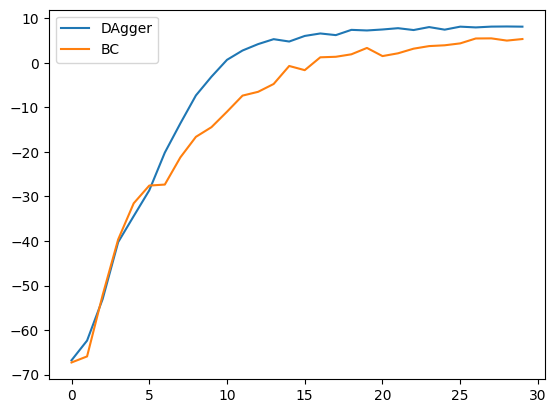

In [10]:
import matplotlib.pyplot as plt

# train with behavior cloning (BC)
# (by setting p_for_beta=1.0)
bc_learner_func = LearnerNet().to(device)
bc_results = train(
    expert=expert_func,
    learner=bc_learner_func,
    p_for_beta=1.0,
    collect_dat=5000,
    total_aggregate=30,
    train_batch_size=200,
)

# plot
plt.plot(dagger_results, label="DAgger")
plt.plot(bc_results, label="BC")
plt.legend()
plt.show()

In [12]:
bc_results

[-67.285,
 -65.925,
 -52.175,
 -39.655,
 -31.535,
 -27.555,
 -27.33,
 -21.225,
 -16.61,
 -14.44,
 -10.965,
 -7.35,
 -6.5,
 -4.74,
 -0.695,
 -1.635,
 1.25,
 1.37,
 1.925,
 3.355,
 1.525,
 2.15,
 3.19,
 3.77,
 3.95,
 4.38,
 5.48,
 5.505,
 5.005,
 5.355]